# University Student Dropout: A Longitudinal Dataset of Demographic, Socioeconomic, and Academic Indicators
In this document I walk through the data provided by this research and do basic training before separating code into final executables


In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
import joblib
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import make_scorer, f1_score

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

## Loading datasets for 2021-2022
The goal is to compare them and merge into single dataset for 2 years
I decided to focus on two most recent datasets

The datasets have relative naming for months like 'pft_events_2021_10'
Rename them to same format and merge

In [4]:
df_2021 = pd.read_csv("../data/raw/dataset_2021_hash.csv", sep=';', low_memory=False, decimal=',')
df_2022 = pd.read_csv("../data/raw/dataset_2022_hash.csv", sep=';', low_memory=False, decimal=',')

In [5]:
print(f"Shapes: 2021:{df_2021.shape}; 2022:{df_2022.shape}")
print(f"Columns: 2021: {len(df_2021.columns)}; 2022:{len(df_2022.columns)}")

cols_2021 = set(df_2021.columns)
cols_2022 = set(df_2022.columns)

print(f"Columns in 2021 but not 2022: {cols_2021 - cols_2022}")
print(f"Columns in 2022 but not 2021: {cols_2022 - cols_2021}")
print(f"Shared columns: {len(cols_2021.intersection(cols_2022))}")

Shapes: 2021:(153120, 178); 2022:(159173, 169)
Columns: 2021: 178; 2022:169
Columns in 2021 but not 2022: {'pft_events_2022_2', 'pft_test_submissions_2022_2', 'n_wifi_days_2021_11', 'n_wifi_days_2022_5', 'pft_test_submissions_2022_5', 'pft_test_submissions_2021_9', 'n_wifi_days_2021_9', 'pft_total_minutes_2022_8', 'n_resource_days_2022_1', 'n_resource_days_2021_12', 'pft_test_submissions_2021_11', 'n_resource_days_2022_8', 'pft_days_logged_2022_5', 'resource_events_2022_1', 'pft_days_logged_2021_12', 'resource_events_2021_12', 'pft_test_submissions_2021_10', 'pft_events_2022_1', 'pft_assignment_submissions_2021_9', 'pft_total_minutes_2022_6', 'pft_events_2022_7', 'pft_total_minutes_2022_2', 'pft_assignment_submissions_2021_10', 'n_wifi_days_2021_12', 'pft_events_2021_11', 'pft_visits_2022_4', 'resource_events_2022_5', 'pft_events_2022_4', 'resource_events_2022_3', 'pft_total_minutes_2021_11', 'pft_total_minutes_2022_3', 'pft_events_2021_10', 'pft_test_submissions_2022_7', 'pft_visits_2

In [6]:
def align_academic_months(df, cohort_year):
    """
    Renames columns like 'pft_events_2021_10' to 'pft_events_m2' 
    assuming September is Month 1.
    """
    new_cols = {}
    for col in df.columns:
        # Match pattern like _2021_9 or _2022_1
        match = re.search(r'_(\d{4})_(\d{1,2})$', col)
        if match:
            year = int(match.group(1))
            month = int(match.group(2))
            
            # Relative month (Sept=1, Oct=2... Aug=12)
            rel_month = (month - 9) % 12 + 1
            
            base_name = col[:match.start()]
            new_cols[col] = f"{base_name}_m{rel_month}"
            
    return df.rename(columns=new_cols)


In [ ]:
df_2021 = align_academic_months(df_2021, 2021)
df_2022 = align_academic_months(df_2022, 2022)

print(f"Shapes: 2021:{df_2021.shape}; 2022:{df_2022.shape}")
print(f"Columns: 2021: {len(df_2021.columns)}; 2022:{len(df_2022.columns)}")

# 2021 set has 9 more columns which we drop by taking intersection:
shared_cols = list(set(df_2021.columns).intersection(set(df_2022.columns)))

df_2021 = df_2021[shared_cols]
df_2022 = df_2022[shared_cols]

cols_2021 = set(df_2021.columns)
cols_2022 = set(df_2022.columns)

print(f"Shared columns: {len(cols_2021.intersection(cols_2022))}")

Shapes: 2021:(153120, 178); 2022:(159173, 169)
Columns: 2021: 178; 2022:169
Shared columns: 169


### Merge both datasets now

In [8]:
# Cohort year indicator
df_2021['cohort_year'] = 2021
df_2022['cohort_year'] = 2022

df_combined = pd.concat([df_2021, df_2022], ignore_index=True)
print(f"Combined shape: {df_combined.shape}")
print(df_combined['abandono_hash'].value_counts())
# Seems that 'B' means not abandoned, 'A' means abandoned
df_combined['target'] = df_combined['abandono_hash'].map({'B': 0, 'A': 1})
df_combined.drop(columns=['abandono_hash'], inplace=True)

Combined shape: (312293, 170)
abandono_hash
B    292561
A     19732
Name: count, dtype: int64


## Data analysis and cleaning

Examining data and preparing it for use in XGBoost

In [9]:
print(f"Shape: {df_combined.shape}")
# print(f"\nHow many missing values per column, given {df_combined.shape[0]} rows")
# print(df_2022.isnull().sum().to_string())

missing_percent = (df_combined.isnull().sum() / len(df_combined)) * 100
print("Percentage of missing values per column:")
print(missing_percent.sort_values(ascending=False).to_string())

print(df_combined.describe().to_string())

df_combined.head()

Shape: (312293, 170)
Percentage of missing values per column:
pft_test_submissions_m11          99.978546
pft_assignment_submissions_m11    99.837973
es_retitulado                     99.585325
total1                            99.180257
es_adaptado                       98.608999
ajuste                            97.629150
impagado_curso_mat                97.592325
n_resource_days_m11               96.003433
resource_events_m11               96.003433
pft_test_submissions_m5           95.493015
pft_test_submissions_m10          95.435376
pft_test_submissions_m1           95.314336
pft_assignment_submissions_m1     94.707854
pft_assignment_submissions_m5     94.604106
pft_assignment_submissions_m10    94.587775
activ1                            94.542945
pft_test_submissions_m8           94.358183
pft_test_submissions_m6           94.304387
pft_visits_m11                    94.255075
pft_total_minutes_m11             94.243547
pft_assignment_submissions_m6     93.635784
pft_test_submi

,pft_events_m7,n_resource_days_m4,pft_days_logged_m10,curso_mas_alto,cred_sup_4o,pft_assignment_submissions_m2,n_resource_days_m9,nota10_hash,caca,pft_visits_m6,n_wifi_days_m9,cred_sup_1o,pft_test_submissions_m3,n_wifi_days_m4,n_resource_days_m8,cred_sup_total,cred_mat3,pft_visits_m4,cred_sup_6o,campus_hash,cred_sup_2o,resource_events_m10,pft_days_logged_m7,curso_mas_bajo,n_resource_days_m3,cred_mat4,anyo_inicio_estudios,pft_assignment_submissions_m4,n_resource_days_m1,nota_asig_hash,pft_visits_m9,cred_pend_sup_tit,n_wifi_days_m7,pft_test_submissions_m4,pft_events_m1,rendimiento_cuat_b,cred_mat_movilidad,pft_test_submissions_m1,cred_sup_5o,cred_mat_total,resource_events_m9,dedicacion,pft_events_m11,cred_ptes_acta,grupos_por_tipocredito_hash,cred_mat_normal,tit_hash,resource_events_m7,pft_visits_m2,rendimiento_total,dni_hash,pft_test_submissions_m11,pft_events_m9,rend_total_penultimo,resource_events_m3,n_wifi_days_m10,cred_sup_espec,cred_mat_sem_a,pft_days_logged_m3,impagado_curso_mat,n_resource_days_m7,pft_assignment_submissions_m3,pft_events_m6,desplazado_hash,estudios_p_hash,cred_sup_sem_b,pft_test_submissions_m8,n_resource_days_m10,pft_total_minutes_m3,pft_visits_m5,pft_assignment_submissions_m9,pft_visits_m8,cred_sup_3o,es_adaptado,pft_test_submissions_m6,n_wifi_days_m11,pft_total_minutes_m1,pft_total_minutes_m4,pft_visits_m11,pft_assignment_submissions_m7,pft_test_submissions_m2,n_wifi_days_m1,pft_total_minutes_m10,cred_mat_anu,pft_assignment_submissions_m11,n_resource_days_m5,preferencia_seleccion,pract1,pft_events_m5,pft_test_submissions_m7,n_resource_days_m11,matricula_activa,pft_visits_m1,resource_events_m5,n_wifi_days_m5,actividades,pft_days_logged_m5,n_wifi_days_m6,asig1,pft_test_submissions_m5,pft_events_m8,fecha_datos,n_wifi_days_m3,cred_mat_sem_b,pft_assignment_submissions_m5,cred_mat6,pft_assignment_submissions_m1,n_resource_days_m6,pft_assignment_submissions_m10,pft_visits_m7,pft_visits_m10,resource_events_m11,pft_test_submissions_m9,cred_sup_tit,cred_sup,n_wifi_days_m2,resource_events_m8,pft_total_minutes_m9,pft_assignment_submissions_m8,activ1,rend_total_antepenultimo,pft_events_m2,cred_mat_practicas,pft_events_m4,pft_total_minutes_m8,resource_events_m2,pft_test_submissions_m10,pft_events_m3,n_wifi_days_m8,rend_total_ultimo,exento_npp,ajuste,tipo_ingreso,practicas,rendimiento_cuat_a,pft_total_minutes_m6,pft_days_logged_m1,resource_events_m6,pft_total_minutes_m7,nota14_hash,pft_days_logged_m6,cred_sup_sem_a,pft_total_minutes_m11,baja_fecha,resource_events_m1,pft_events_m10,pft_assignment_submissions_m6,anyo_ingreso,pft_days_logged_m4,pft_total_minutes_m2,cred_mat1,n_resource_days_m2,ajuste1,pft_days_logged_m9,cred_mat5,cred_mat2,pft_total_minutes_m5,es_retitulado,pft_days_logged_m8,asi_hash,cred_sup_normal,estudios_m_hash,total1,cred_sup_anu,pft_days_logged_m2,pft_days_logged_m11,resource_events_m4,pft_visits_m3,cohort_year,target
0,NaN,NaN,NaN,3,0.0,NaN,NaN,NaN,2021,NaN,4.0,60.0,NaN,NaN,NaN,37.5,42.0,NaN,0,e4f95d56d90df35e,60.0,NaN,NaN,3,NaN,0.0,2012,NaN,NaN,5.5,NaN,32.34,4.0,NaN,NaN,85.71,0.0,NaN,0.0,42.0,NaN,TC,NaN,0.0,e7d0293bc1c5cb4a,42.0,620c9c332101,NaN,NaN,89.29,319636fc9270,NaN,NaN,100.0,NaN,3.0,0.0,10.5,NaN,NaN,NaN,NaN,NaN,A,F,27.0,NaN,NaN,NaN,NaN,NaN,NaN,55.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,1.0,3.66,NaN,4.0,37.5,NaN,NaN,2023-06-28 14:19:30,NaN,31.5,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.66,37.5,NaN,NaN,NaN,NaN,NaN,100.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,1.0,100.0,NaN,NaN,NAP,0.0,100.0,NaN,NaN,NaN,NaN,9.456,NaN,10.5,NaN,NaN,NaN,NaN,NaN,2012.0,NaN,NaN,0.0,NaN,0,NaN,0.0,0.0,NaN,NaN,NaN,378cc790fd99,37.5,L,NaN,0.0,NaN,NaN,NaN,NaN,2021,0
1,NaN,NaN,NaN,3,0.0,NaN,NaN,NaN,2021,NaN,4.0,60.0,NaN,NaN,NaN,37.5,42.0,NaN,0,e4f95d56d90df35e,60.0,NaN,NaN,3,NaN,0.0,2012,NaN,NaN,6.0,NaN,32.34,4.0,NaN,NaN,85.71,0.0,NaN,0.0,42.0,NaN,TC,NaN,0.0,b9d618bf3e564eb9,42.0,620c9c332101,NaN,NaN,89.29,319636fc9270,NaN,NaN,100.0,NaN,3.0,0.0,10.5,NaN,NaN,NaN,NaN,NaN,A,F,27.0,NaN,NaN,NaN

We need to check how much data is actually missing or can be replaced with values and used

Some high cardinality values can be reduced to data range like the "pft_minutes"
Low cardinality (<=1) should be dropped (don't ignore NaN for those columns)

In [10]:
# Identify high cardinality columns (many unique values)
print(df_combined.nunique(dropna=False).sort_values(ascending=False))
# 0 variance column
# 'matricula_activa' and 'baja_fecha' are leaks (they reveal the outcome).
# 'dni_hash' and 'asi_hash' are IDs (cause overfitting).
cols_to_drop = [
    'dni_hash', 'grupos_por_tipocredito_hash', 'asi_hash', 
    'fecha_datos', 'caca', 'ajuste1',
    'matricula_activa', 'baja_fecha' 
]

df_combined = df_combined.drop(columns=cols_to_drop, errors='ignore')
print(f"New shape after dropping IDs and constants: {df_combined.shape}")

pft_total_minutes_m6              131079
pft_total_minutes_m1              128712
pft_total_minutes_m5              126871
pft_total_minutes_m2              120068
pft_total_minutes_m3              117964
pft_total_minutes_m4              112150
pft_total_minutes_m7              105874
pft_total_minutes_m9              104492
pft_total_minutes_m8               98173
pft_total_minutes_m10              95493
dni_hash                           27067
pft_total_minutes_m11              17319
grupos_por_tipocredito_hash         8351
nota14_hash                         6081
asi_hash                            4249
nota10_hash                         3885
cred_sup_tit                        1627
cred_pend_sup_tit                   1262
rendimiento_total                   1006
pft_events_m9                        995
pft_events_m3                        958
pft_events_m7                        922
pft_events_m5                        890
rend_total_ultimo                    861
pft_events_m10  

Fix the NaNs by replacing them with 0's

Based on study descriptions

XGBoost can't handle strings natively, so we need to convert columns like _hash into `category`

In [11]:
# 1. List the specific binary columns (Where NaN = "No")
binary_cols = ['impagado_curso_mat', 'es_adaptado', 'es_retitulado', 'exento_npp']
# 2. Find all activity columns dynamically (Where NaN = "Zero activity")
# This grabs every column starting with 'pft_' or 'resource_'
# Note how we leave leave Grades as NaN
binary_cols = ['impagado_curso_mat', 'es_adaptado', 'es_retitulado', 'exento_npp']
activity_cols = [c for c in df_combined.columns if c.startswith('pft_') or c.startswith('resource_') or 'wifi' in c]

# Fill these with 0
fill_zero_cols = binary_cols + activity_cols
df_combined[fill_zero_cols] = df_combined[fill_zero_cols].fillna(0)

# 3. CONVERT TYPES
# Ensure categoricals are 'category' and numeric imputed cols are float
for col in df_combined.select_dtypes(include=['object']).columns:
    df_combined[col] = df_combined[col].astype('category')

for col in fill_zero_cols:
    df_combined[col] = pd.to_numeric(df_combined[col])

print("Data Cleaned. Leaks removed. Missing values handled.")

Data Cleaned. Leaks removed. Missing values handled.


## Hyperparameter tuning
We are gonna tune hyperparamteres of XGBoost via kfold cross validation

In [12]:
X = df_combined.drop(columns=['target'])
y = df_combined['target']

# Calculate Imbalance Ratio
ratio = (y == 0).sum() / (y == 1).sum()

We have imbalanced classes B >> A
To improve performance of XGBoost we need to scale weights in xgboost parameters


In [ ]:
xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    tree_method='hist', # 'hist' is required for efficient categorical support
    enable_categorical=True,
    scale_pos_weight=ratio,
    n_jobs=-1,
    random_state=42
)

Hypertuning model
Before training main model we want to hypertune parameters via k folds cross validation to see what leads to best result

In [14]:
param_dist = {
    'n_estimators': [50, 150, 250, 350],
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [4, 6, 8, 10],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'min_child_weight': [1, 3, 5]
}

# Run Search

IMPORTANT: n_jobs=1 here prevents the MemoryError. 

In [15]:

# We let XGBoost handle the parallelism internally.
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=10,
    scoring='f1',
    cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42),
    verbose=1,
    n_jobs=1,
    random_state=42
)

print("Starting Tuning...")
random_search.fit(X, y)

Starting Tuning...
Fitting 3 folds for each of 10 candidates, totalling 30 fits


,"estimator estimator: estimator objectAn object of that type is instantiated for each grid point.This is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.","XGBClassifier...ree=None, ...)"
,"param_distributions param_distributions: dict or list of dictsDictionary with parameters names (`str`) as keys and distributionsor lists of parameters to try. Distributions must provide a ``rvs``method for sampling (such as those from scipy.stats.distributions).If a list is given, it is sampled uniformly.If a list of dicts is given, first a dict is sampled uniformly, andthen a parameter is sampled using that dict as above.","{'colsample_bytree': [0.8, 1.0], 'learning_rate': [0.05, 0.1, ...], 'max_depth': [4, 6, ...], 'min_child_weight': [1, 3, ...], ...}"
,"n_iter n_iter: int, default=10Number of parameter settings that are sampled. n_iter tradesoff runtime vs quality of the solution.",10
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.If None, the estimator's score method is used.",'f1'
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",1
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given the ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``RandomizedSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... v

Final model based on best parameters after kfold

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# 1. Hold out 20% just for peace of mind
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# 2. Train on 80%
sanity_model = xgb.XGBClassifier(**best_params)
sanity_model.fit(X_train, y_train)

# 3. Check score
print("--- Final Hold-Out Test Report ---")
print(classification_report(y_test, sanity_model.predict(X_test)))

--- Final Hold-Out Test Report ---
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     58513
           1       0.91      0.99      0.95      3946

    accuracy                           0.99     62459
   macro avg       0.95      0.99      0.97     62459
weighted avg       0.99      0.99      0.99     62459



In [16]:

best_params = random_search.best_params_

best_params.update({
    'objective': 'binary:logistic',
    'tree_method': 'hist',
    'enable_categorical': True,
    'scale_pos_weight': ratio,
    'n_jobs': -1,
    'random_state': 42
})

final_model = xgb.XGBClassifier(**best_params)

# Train on FULL Dataset
print("Training final production model...")
final_model.fit(X, y)

# Save Model & Feature List
final_model.save_model("dropout_model_final.json")
joblib.dump(X.columns.tolist(), "model_features.pkl")
print("Model and features saved successfully.")

Training final production model...
Model and features saved successfully.


Visualisation

C:\Users\agnen\AppData\Local\Temp\ipykernel_19068\3448206280.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_imp.head(15), palette='viridis')


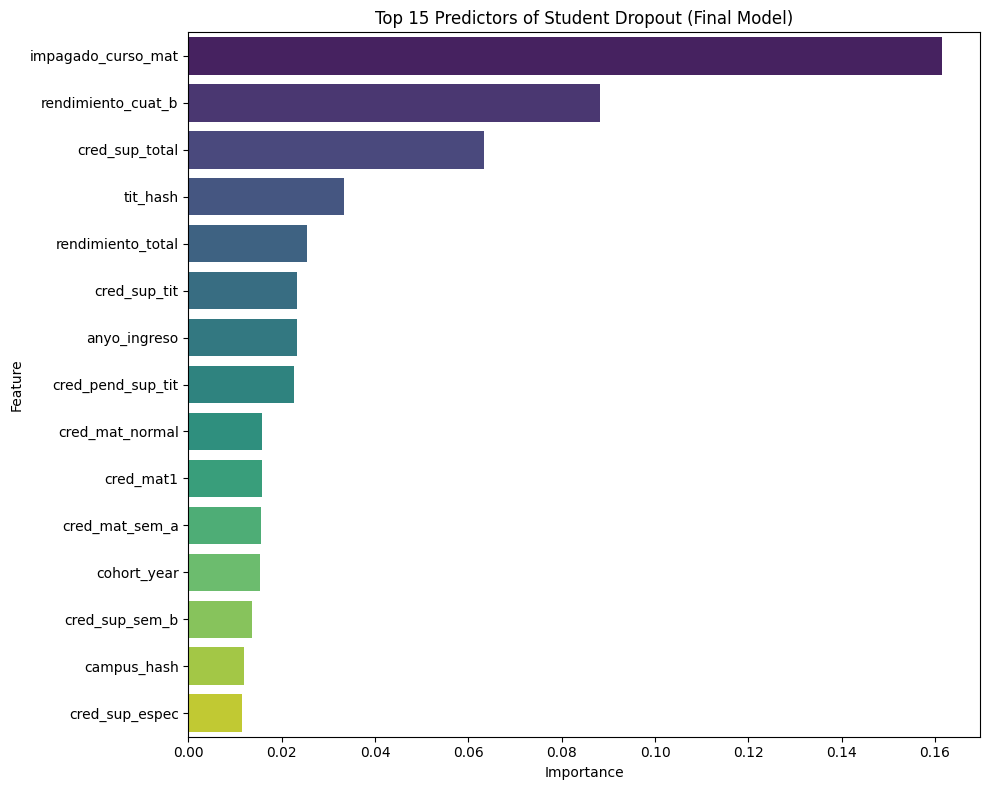

In [17]:
# Plot Feature Importance
feature_imp = pd.DataFrame({
    'Feature': X.columns,
    'Importance': final_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=feature_imp.head(15), palette='viridis')
plt.title('Top 15 Predictors of Student Dropout (Final Model)')
plt.tight_layout()
plt.savefig('feature_importance.png')
plt.show()